In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import joblib

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from expected_score_model.predict import predict_xscore_from_chains

In [3]:
xscore_model = joblib.load("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models/catboost_xscore_model.joblib")

In [4]:
from expected_score_model.evaluation.model_evaluator import ModelEvaluator
from expected_score_model.evaluation.classification_evaluator import ClassificationModelEvaluator
from expected_score_model.evaluation.regression_evaluator import RegressionModelEvaluator
from expected_score_model.evaluation.catboost_evaluator import CatBoostEvaluator

In [5]:
from AFLPy.AFLData_Client import load_data, upload_data

In [6]:
chains = load_data(Dataset_Name="AFL_API_Match_Chains", ID = "AFL")

In [7]:
from expected_score_model.preprocessing.response import create_expected_score_response

In [8]:
chains = create_expected_score_response(chains).reset_index(drop=True)

In [9]:
chains.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal
0,NaN,1,Brisbane,centreBounce,turnover,1.0,0.0,Centre Bounce,NaN,NaN,NaN,1.0,0.0,0.0,0.0,Sydney,Brisbane,right,141.0,160.0,NaN,NaN,AFL_2024_F4_Sydney_Brisbane,NaN,miss,0,1,0,0
1,CD_I293535,1,Brisbane,centreBounce,turnover,1.0,0.0,Hard Ball Get,NaN,NaN,NaN,2.0,8.0,-12.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Lachie Neale,Brisbane,AFL_2024_F4_Sydney_Brisbane,lachie_neale,miss,0,1,0,0
2,CD_I293535,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball,effective,NaN,NaN,3.0,8.0,-13.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Lachie Neale,Brisbane,AFL_2024_F4_Sydney_Brisbane,lachie_neale,miss,0,1,0,0
3,CD_I1002401,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball Received,NaN,NaN,NaN,4.0,10.0,-19.0,-13.0,Sydney,Brisbane,right,141.0,160.0,Brandon Starcevich,Brisbane,AFL_2024_F4_Sydney_Brisbane,brandon_starcevich,miss,0,1,0,0
4,CD_I1002401,1,Brisbane,centreBounce,turnover,1.0,0.0,Handball,effective,NaN,NaN,5.0,10.0,-19.0,-11.0,Sydney,Brisbane,right,141.0,160.0,Brandon Starcevich,Brisbane,AFL_2024_F4_Sydney_Brisbane,brandon_starcevich,miss,0,1,0,0


Preprocessing

In [10]:
xs_preproc = joblib.load("/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors/xscore_preprocessor.joblib")
X_shots, y_shots = xs_preproc.fit_transform(chains, chains['result'])

In [11]:
X_shots.head(1)

,Description_grouped,angle,angle_degrees,chain_duration,description_grouped_0,description_grouped_1,description_grouped_2,description_grouped_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3
47,Kick,0.321751,18.434949,68.0,Kick,Mark,Kick,Other,37.947332,3.636199,8.246211,1440.0,36.0,12.0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0


Feature Selection

In [12]:
selected_features = ['distance', 'angle', 'set_shot', 'distance_since_last_action']
X_shots_selected = X_shots[selected_features]

Evaluation

In [13]:
class_names = xscore_model.cb_clf.classes_
predicted_probabilities = xscore_model.predict_proba(X_shots_selected)

class_probabilities = {f'predicted_proba_{class_names[i]}': predicted_probabilities[:, i] for i in range(len(class_names))}

In [14]:
predicted_score = class_probabilities['predicted_proba_goal']*6 + class_probabilities['predicted_proba_behind']*1
predicted_result = xscore_model.predict(X_shots_selected).flatten()

In [15]:
score = chains.loc[y_shots.index, 'score']
goal = chains.loc[y_shots.index, 'goal']
behind = chains.loc[y_shots.index, 'behind']
miss = chains.loc[y_shots.index, 'miss']

actuals_binary = np.array(chains.loc[y_shots.index, xscore_model.classes_])

Model Evaluation

In [16]:
model_eval = ModelEvaluator(model = xscore_model)

In [17]:
score.sum(), predicted_score.sum()

(138131, 137803.20290999016)

In [18]:
model_eval.averages(actual = score, predicted = predicted_score)

{'actual': 3.2987295218990305, 'predicted': 3.2909013447482964}

In [19]:
model_eval.averages(actual = goal, predicted = class_probabilities['predicted_proba_goal'])

{'actual': 0.4922386206237761, 'predicted': 0.4908760638047779}

In [20]:
model_eval.averages(actual = behind, predicted = class_probabilities['predicted_proba_behind'])

{'actual': 0.3452977981563739, 'predicted': 0.345644961919628}

In [21]:
model_eval.averages(actual = miss, predicted = class_probabilities['predicted_proba_miss'])

{'actual': 0.16246358121985002, 'predicted': 0.163478974275594}

Modelled Features

In [ ]:
from pandas.api.types import is_numeric_dtype

In [ ]:
self = model_eval
feature = X_shots_selected['distance_since_last_action']
plot_data = self._get_feature_plot_data(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = feature)
# if is_numeric_dtype(feature) & (len(np.unique(feature)) > 50):
#     plot_data = self._group_feature(plot_data)

In [ ]:
bin_edges.shape

In [ ]:
data = plot_data.copy()
bins = 10

_, bin_edges = pd.qcut(data['feature'], q=bins, retbins=True, duplicates='drop')

if np.unique(bin_edges.astype(int)).shape[0] == bins+1:
    bin_edges = bin_edges.astype(int)
else:
    bin_edges = np.round(bin_edges, 2)

labels = [f'({bin_edges[i]}, {bin_edges[i + 1]}]' for i in range(len(bin_edges) - 1)]
data['feature'] = pd.cut(data['feature'], bins=bin_edges, labels=labels, include_lowest=True)

In [ ]:
plot_data

In [ ]:
self._aggregate_actual_expected(data)

In [ ]:
plot_data

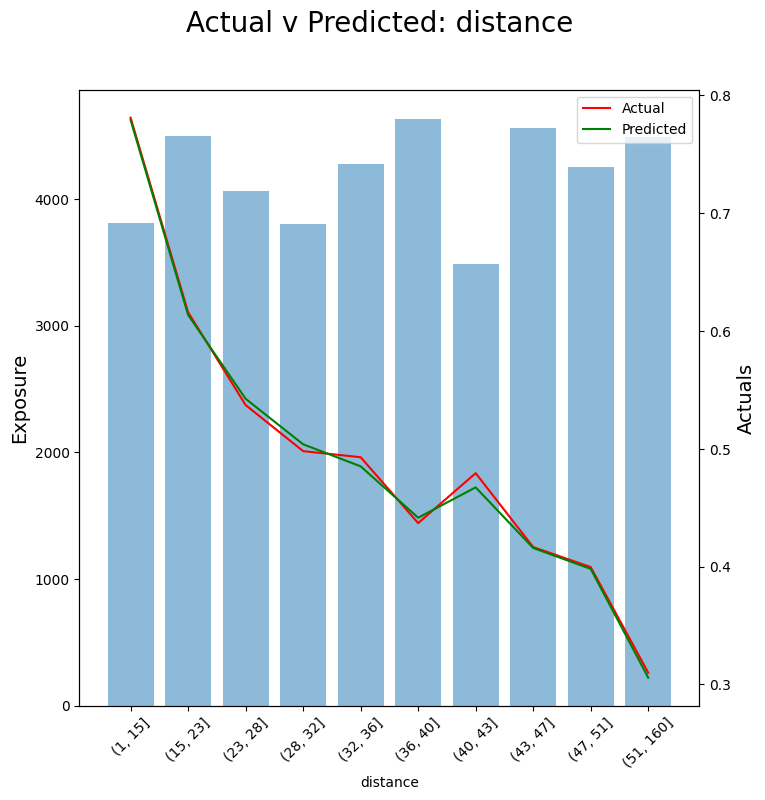

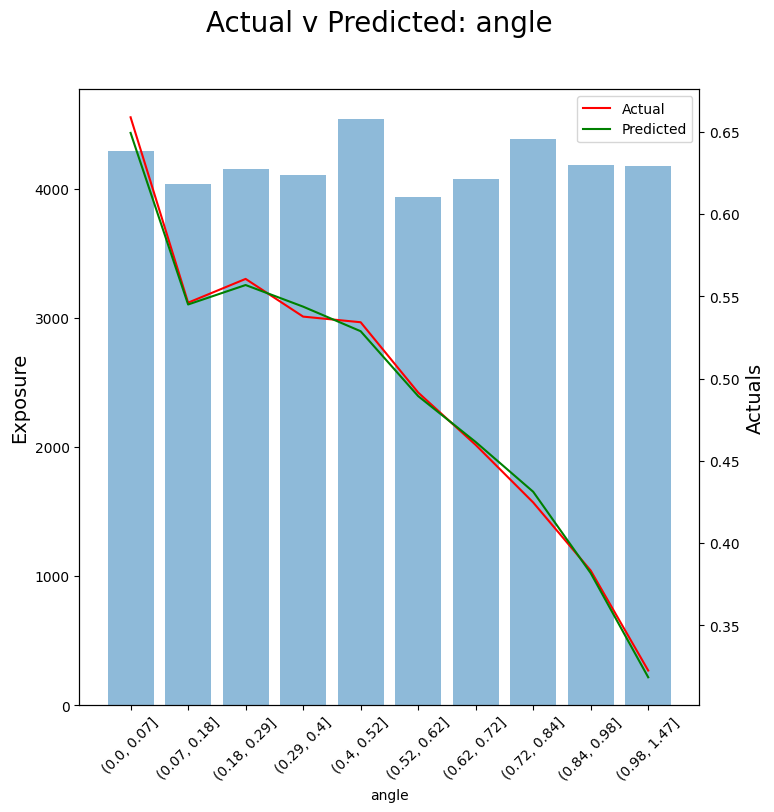

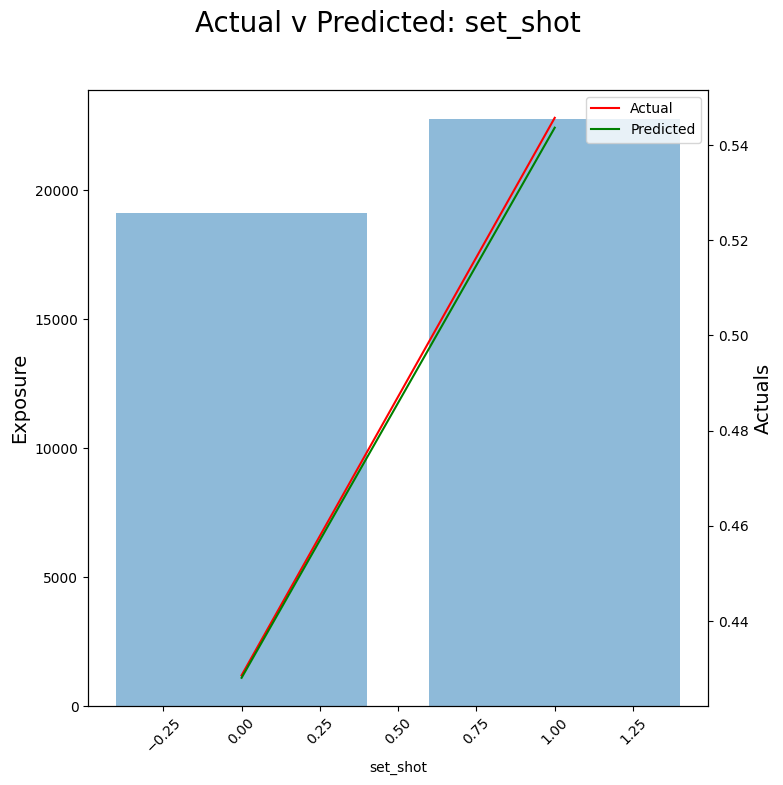

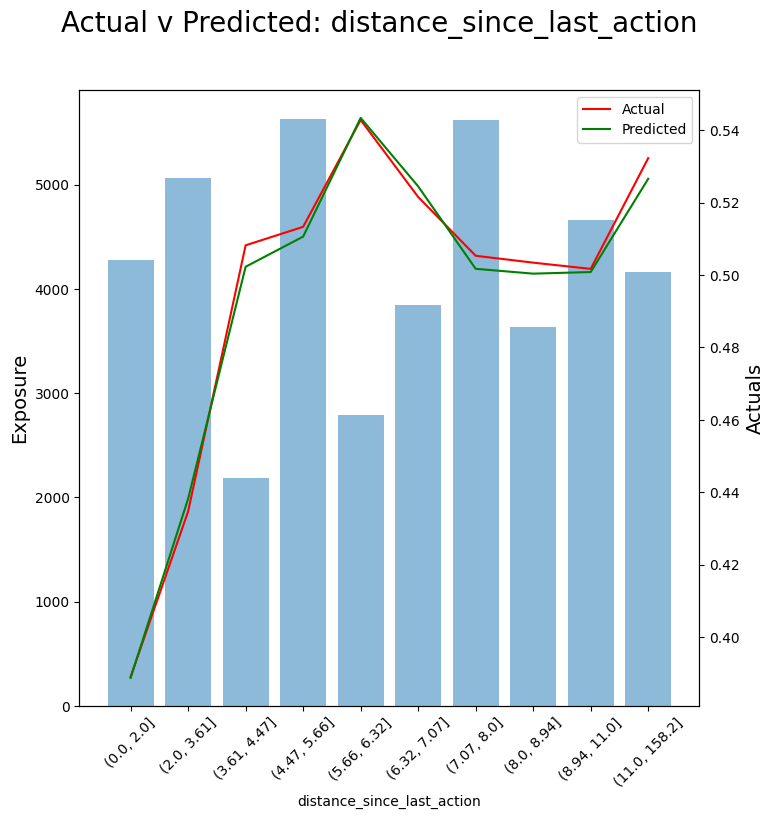

In [22]:
for feature in xscore_model.cb_clf.feature_names_:
    fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots_selected[feature], feature_name = feature)
    fig.savefig(f'../_figures/{feature}.png')

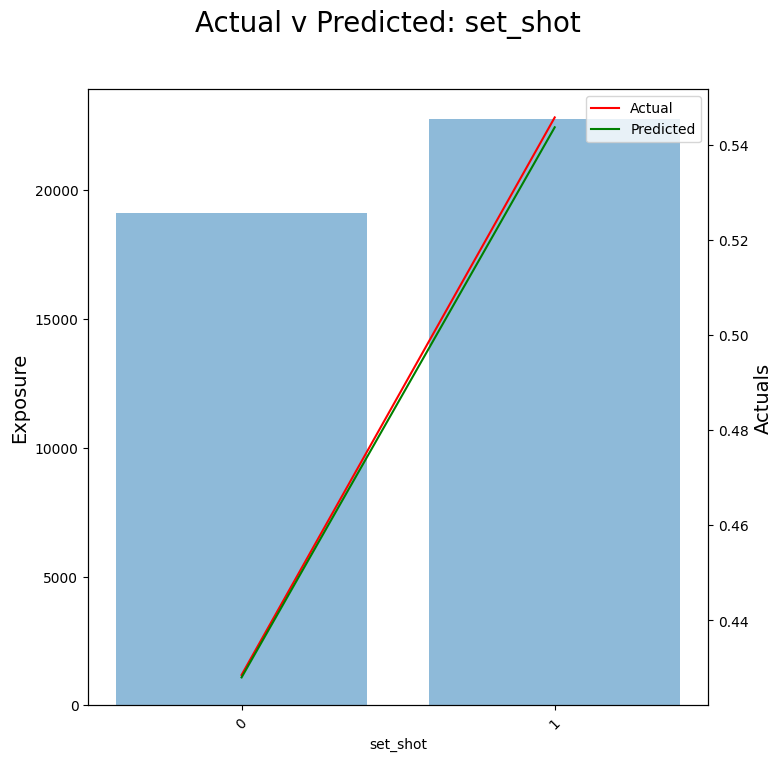

In [29]:
fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots_selected['set_shot'], feature_name = 'set_shot')
ax[0].set_xticks([0, 1])
fig.savefig(f'../_figures/set_shot.png')

Extra Features

In [ ]:
# candidate_features = sorted(list(set(X_shots.columns) - set(X_shots_selected)))
# for feature in candidate_features:
#     fig, ax = model_eval.plot_feature_ave(actual = goal, predicted = class_probabilities['predicted_proba_goal'], feature = X_shots.loc[X_test.index][feature], feature_name = feature)

Classification

In [ ]:
multi_class_model_eval = ClassificationModelEvaluator(model = xscore_model, classification_type='multi')

In [ ]:
xscore_model.classes_

In [ ]:
actual_label = y_shots
predicted_label = predicted_result

In [ ]:
multi_class_model_eval.get_log_loss(actual = actuals_binary, predictions = predicted_probabilities)

In [ ]:
multi_class_model_eval.get_brier_score_loss(actual = actuals_binary, predictions = predicted_probabilities)

In [ ]:
from sklearn.calibration import CalibrationDisplay


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
CalibrationDisplay.from_predictions(actuals_binary[:, 1], predicted_probabilities[:, 1], n_bins=10, ax=ax)
fig.savefig('../_figures/calibration_display.png')

In [ ]:
multi_class_model_eval.display_calibration_curve(actual = actuals_binary, predictions = predicted_probabilities, nbins=10) 

In [ ]:
multi_class_model_eval.get_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [ ]:
multi_class_model_eval.display_confusion_matrix(actual_label=actual_label, predicted_label=predicted_label)

In [ ]:
specified_class = 'goal'
class_label = np.where(actual_label == specified_class, 1, 0)
predicted_class_label = np.where(predicted_label == specified_class, 1, 0)

In [ ]:
multi_class_model_eval.plot_roc_curve(actual_label=class_label, predicted_label=predicted_class_label)

In [ ]:
multi_class_model_eval.plot_prauc_curve(actual_label=class_label, predicted_label=predicted_class_label)

In [ ]:
regression_model_eval = RegressionModelEvaluator(model = xscore_model)

In [ ]:
fig, ax = regression_model_eval.plot_decile(actual = score, predictions = predicted_score)

In [ ]:
fig, ax = regression_model_eval.plot_distribution(actual = score, predictions = predicted_score)

In [ ]:
fig, ax = regression_model_eval.plot_ave(actual = score, predictions = predicted_score)

CatBoost Evaluation

In [ ]:
cb_model_evaluator = CatBoostEvaluator(
    catboost_model = xscore_model.cb_clf,
    evaluator = ClassificationModelEvaluator
)   

In [ ]:
fig, ax = cb_model_evaluator.plot_feature_importance()
fig.savefig('../_figures/catboost_feature_importance.png')

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(cb_model_evaluator.catboost_model)
shap_values = explainer(X_shots_selected, y_shots)

if (len(cb_model_evaluator.catboost_model.classes_) > 1) & (specified_class is not None):
    ind = list(cb_model_evaluator.catboost_model.classes_).index(specified_class)
    
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(shap_values[..., ind], max_display=10, show=False)
    
    fig = plt.gcf()  # Get the current figure
    fig.savefig("../_figures/shap_beeswarm_plot.png", format="png", bbox_inches="tight")

    plt.close()

In [ ]:
plt.figure(figsize=(10, 6))

cb_model_evaluator.plot_shap_beeswarm(X_shots_selected, y_shots, specified_class='goal', max_display=10)

# Save the figure as a PNG
plt.savefig('../_figures/shap_beeswarm_plot.png', format="png")
plt.close()

In [ ]:
cb_model_evaluator.plot_shap_beeswarm(X_shots_selected, y_shots, specified_class='goal', max_display=10)